In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.8.0


In [3]:
!wget https://firebasestorage.googleapis.com/v0/b/haunt-4.appspot.com/o/clouds.zip

--2022-02-24 17:05:21--  https://firebasestorage.googleapis.com/v0/b/haunt-4.appspot.com/o/clouds.zip?alt=media
Resolving firebasestorage.googleapis.com (firebasestorage.googleapis.com)... 142.250.141.95, 2607:f8b0:4023:c0b::5f
Connecting to firebasestorage.googleapis.com (firebasestorage.googleapis.com)|142.250.141.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48949704 (47M) [application/x-zip-compressed]
Saving to: ‘clouds.zip?alt=media’

clouds.zip?alt=medi 100%[===================>]  46.68M  14.0MB/s    in 3.3s    

2022-02-24 17:05:26 (14.0 MB/s) - ‘clouds.zip?alt=media’ saved [48949704/48949704]



In [4]:
import os

os.rename('/content/clouds.zip?alt=media', '/content/clouds.zip')

In [5]:
import zipfile
with zipfile.ZipFile("/content/clouds.zip","r") as zip_ref:
    zip_ref.extractall("/content/clouds")

In [6]:
import pathlib
data_dir = "/content/clouds"                                    
data_dir = pathlib.Path(data_dir)



In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

9000


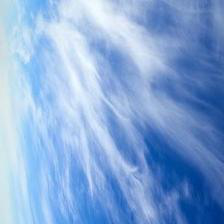

In [8]:
clouds = list(data_dir.glob('cirrus/*'))
PIL.Image.open(str(clouds[290]))

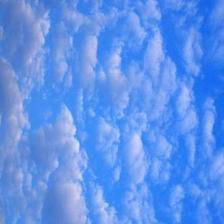

In [10]:
clouds = list(data_dir.glob('altocumulus/*'))
PIL.Image.open(str(clouds[49]))

In [11]:
batch_size = 32
img_height = 224
img_width = 224

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 7200 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['altocumulus', 'cirrocumulus', 'cirrostratus', 'cirrus', 'cumulonimbus', 'cumulus', 'nimbostratus', 'stratocumulus', 'stratus']


In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.14117648 0.91372555


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  
  tf.keras.layers.Dense(9, activation='softmax'),
])

In [21]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

In [ ]:
model.save('/content/model.h5')

In [ ]:
import urllib.request

urllib.request.urlretrieve("https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/Cirrus_clouds2.jpg/800px-Cirrus_clouds2.jpg", "/content/cir.jpg")

('/content/cir.jpg', <http.client.HTTPMessage at 0x7feb3bae0c90>)

In [ ]:
pred = model.input_shape
pred

(None, 224, 224, 3)

In [ ]:
from PIL import Image
img = Image.open('/content/cir.jpg')

In [ ]:
img = img.resize((224,224))
print(np.asarray(img).shape)
img = np.asarray(img)

(224, 224, 3)


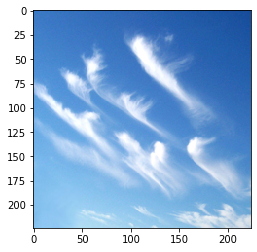

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(img, interpolation='nearest')
plt.show()

In [ ]:
classes = ['altocumulus', 'cirrocumulus', 'cirrostratus', 'cirrus', 'cumulonimbus', 'cumulus', 'nimbostratus', 'stratocumulus', 'stratus']

In [ ]:
# img = img
prediction = model.predict(np.resize(img, new_shape=(1,224,224,3)))
lol = tf.nn.softmax(prediction).numpy()
prediction = lol
print(prediction)
classes[np.argmax(prediction)]

[[0.11866417 0.09357315 0.12215319 0.12447073 0.10457605 0.12055609
  0.08871073 0.10779671 0.11949909]]


'cirrus'